In [ ]:
#import of the used packages
!pip install Scrapy -q
!pip install Plotly -q
import plotly.io as pio
pio.renderers.default = "iframe_connected"
from tqdm import tqdm
from datetime import datetime
import os
import logging
import scrapy
from scrapy.crawler import CrawlerProcess
import requests
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Collect GPS coordinates from city names

In [2]:
#request test to the Nominatim API
r = requests.get("https://nominatim.openstreetmap.org/?country=france&city=nancy&format=json")
r

<Response [200]>

In [3]:
#"Chateau du Haut Koenigsbourg" is replaced by the city of Orschwiller because this is not the name of a city
#"Gorges du Verdon" is replaced by the city of La Palud-sur-Verdon because this is not the name of a city
#"Ariege" is replaced by the city of Foix because this is not the name of a city (Foix is the prefecture)
cities_list = ["Mont Saint Michel",
                   "St Malo",
                   "Bayeux",
                   "Le Havre",
                   "Rouen",
                   "Paris",
                   "Amiens",
                   "Lille",
                   "Strasbourg",
                   "Orschwiller",
                   "Colmar",
                   "Eguisheim",
                   "Besancon",
                   "Dijon",
                   "Annecy",
                   "Grenoble",
                   "Lyon",
                   "La Palud-sur-Verdon",
                   "Bormes les Mimosas",
                   "Cassis",
                   "Marseille",
                   "Aix en Provence",
                   "Avignon",
                   "Uzes",
                   "Nimes",
                   "Aigues Mortes",
                   "Saintes Maries de la mer",
                   "Collioure",
                   "Carcassonne",
                   "Foix",
                   "Toulouse",
                   "Montauban",
                   "Biarritz",
                   "Bayonne",
                   "La Rochelle"]

In [4]:
#Loop to the Nominatim API to get the GPS coordonates for each city
df_cities = pd.DataFrame(columns = r.json()[0].keys())
for city in tqdm(cities_list, colour = "green"):
    city_data = requests.get("https://nominatim.openstreetmap.org/?q={}&country=france&format=json".format(city))
    df_cities = df_cities.append(city_data.json()[0],ignore_index = True)

100%|██████████| 35/35 [00:17<00:00,  2.00it/s]


In [5]:
#data cleaning
df_cities.drop(["place_id", "licence", "osm_type", "osm_id", "boundingbox", "class", "type", "importance", "icon"], axis=1, inplace=True)
df_cities = df_cities.rename(columns={'display_name': 'city_name', 'lat': 'latitude', 'lon': 'longitude'})
df_cities["city_name"] = df_cities["city_name"].str.split(',').str[0]
df_cities.loc[:, ["city_name","latitude","longitude"]]
lat_list = df_cities["latitude"].tolist()
lon_list = df_cities["longitude"].tolist()
df_cities['latitude'] = pd.to_numeric(df_cities['latitude'])
df_cities['longitude'] = pd.to_numeric(df_cities['longitude'])
df_cities['latitude'].round(decimals=7)
df_cities['longitude'].round(decimals=7)
df_cities.head(5)

,latitude,longitude,city_name
0,48.635523,-1.510257,Le Mont-Saint-Michel
1,48.649518,-2.026041,Saint-Malo
2,49.276462,-0.702474,Bayeux
3,49.493897,0.107973,Le Havre
4,49.440459,1.093966,Rouen


# Collect weather data for each city

In [6]:
#Loop to the Openweathermap API to get the weather for each GPS coordonate
from datetime import datetime

url = "https://api.openweathermap.org/data/2.5/onecall"
lat = lat_list
lon = lon_list
params = {"exclude": "hourly,current,minutely",
          "appid": "f8c6d352313be73cf5752650d84b0b5a",
          "units": "metric"}
columns = ['date', 'latitude', 'longitude',
           'temperature', 'wind_speed', 'clouds']
DATA = []
with requests.Session() as session:
    for lat, lon in zip(lat, lon):
        for nb_days in range (0,6):
            params['lat'] = lat
            params['lon'] = lon
            r = session.get(url, params=params)
            r.raise_for_status()
            d = r.json()['daily'][nb_days]
            dt = datetime.fromtimestamp(d['dt']).strftime('%d/%m/%Y')
            DATA.append([dt, lat, lon, d['temp']['day'],
                        d['wind_speed'], d['clouds']])
df_cities_weather = pd.DataFrame(DATA, columns=columns)
pd.set_option('display.max_rows', None)


In [7]:
#data cleaning
df_cities_weather['latitude'] = pd.to_numeric(df_cities_weather['latitude'])
df_cities_weather['longitude'] = pd.to_numeric(df_cities_weather['longitude'])
df_cities_weather['latitude'].round(decimals=7)
df_cities_weather['longitude'].round(decimals=7)

0     -1.510257
1     -1.510257
2     -1.510257
3     -1.510257
4     -1.510257
5     -1.510257
6     -2.026041
7     -2.026041
8     -2.026041
9     -2.026041
10    -2.026041
11    -2.026041
12    -0.702474
13    -0.702474
14    -0.702474
15    -0.702474
16    -0.702474
17    -0.702474
18     0.107973
19     0.107973
20     0.107973
21     0.107973
22     0.107973
23     0.107973
24     1.093966
25     1.093966
26     1.093966
27     1.093966
28     1.093966
29     1.093966
30     2.351462
31     2.351462
32     2.351462
33     2.351462
34     2.351462
35     2.351462
36     2.295695
37     2.295695
38     2.295695
39     2.295695
40     2.295695
41     2.295695
42     3.063528
43     3.063528
44     3.063528
45     3.063528
46     3.063528
47     3.063528
48     7.750713
49     7.750713
50     7.750713
51     7.750713
52     7.750713
53     7.750713
54     7.379981
55     7.379981
56     7.379981
57     7.379981
58     7.379981
59     7.379981
60     7.357964
61     7.357964
62     7

In [8]:
#join on the GPS coordonnates and the weather data & column names cleaning
df_cities_weather = df_cities_weather.merge(df_cities, on='latitude', how='inner')


In [9]:
df_cities_weather = df_cities_weather.rename(columns={"latitude": "city_latitude", "longitude_x": "city_longitude"})#
del df_cities_weather["longitude_y"]

# Booking hotels scraping

In [10]:
#Booking scraping for the first part of city list
class BookingSpider(scrapy.Spider):
    
    name = "hotels_sraping"      
    
    list_url = []
    for i in range (0, len(cities_list)):
        list_url.append("https://www.booking.com/searchresults.fr.html?ss={}&order=bayesian_review_score".format(cities_list[i]))
        
    start_urls = list_url                
    
    def parse(self, response):
        hotels = response.css('div.sr_item_no_dates')
        for hotel in hotels:
            yield {
                'hotel_name': hotel.css('span.sr-hotel__name::text').get(),
                'hotel_review': hotel.css('div.bui-review-score__badge::text').get(),
                'hotel_description': hotel.css('div.hotel_desc::text').get(),
                'hotel_link': 'https://www.booking.com'+hotel.css('a::attr(href)').get(),
                'city_name': hotel.css('a.bui-link::text').get(),
                'gps_coordinates': hotel.css('a.bui-link::attr(data-coords)').get(),
            }

    #    try:
            # Select the NEXT button and store it in next_page
         #   next_page = response.css('li.bui-pagination__next-arrow a').attrib["href"]
     #   except KeyError:
            # In the last page, there won't be any "href" and a KeyError will be raised
       #     logging.info('No next page. Terminating crawling process.')
      #  else:
            # If a next page is found, execute the parse method once again
        #    yield response.follow(next_page, callback=self.parse)

In [11]:
filename = "booking_top_hotels.json"

if filename in os.listdir('src/'):
        os.remove('src/' + filename)

# Declare a new CrawlerProcess with some settings
## USER_AGENT => Simulates a browser on an OS
## LOG_LEVEL => Minimal Level of Log 
## FEEDS => Where the file will be stored 
## More info on built-in settings => https://docs.scrapy.org/en/latest/topics/settings.html?highlight=settings#settings
process = CrawlerProcess(settings = {
    'USER_AGENT': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36',
    'LOG_LEVEL': logging.INFO,
    "FEEDS": {
        'src/' + filename : {"format": "json"},
    },
    "AUTOTHROTTLE_ENABLED": True
})

process.crawl(BookingSpider)
process.start()

2021-10-10 15:05:56 [scrapy.utils.log] INFO: Scrapy 2.5.1 started (bot: scrapybot)
2021-10-10 15:05:56 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 21.7.0, Python 3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05) - [GCC 7.5.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1h  22 Sep 2020), cryptography 3.1.1, Platform Linux-5.4.129+-x86_64-with-glibc2.10
2021-10-10 15:05:56 [scrapy.crawler] INFO: Overridden settings:
{'AUTOTHROTTLE_ENABLED': True,
 'LOG_LEVEL': 20,
 'USER_AGENT': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) '
               'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 '
               'Safari/537.36'}
2021-10-10 15:05:56 [scrapy.extensions.telnet] INFO: Telnet Password: 8a9b3c7e9986d014
2021-10-10 15:05:56 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',

In [12]:
#Export of the scraping results to a .json file
df_hotels = pd.read_json('src/booking_top_hotels.json')

2021-10-10 15:06:19 [numexpr.utils] INFO: NumExpr defaulting to 4 threads.


In [13]:
#Data cleaning
df_hotels['hotel_name'] = df_hotels['hotel_name'].str.replace(r'\n', '')
df_hotels['hotel_review'] = df_hotels['hotel_review'].str.replace(r',', '.')
df_hotels['hotel_review'] = df_hotels['hotel_review'].astype(float)
df_hotels['hotel_description'] = df_hotels['hotel_description'].str.replace(r'\n', '')
df_hotels['city_name'] = df_hotels['city_name'].str.replace(r'\n', '')
df_hotels[['longitude','latitude']] = df_hotels['gps_coordinates'].str.split(',',expand=True)
del df_hotels["gps_coordinates"]
df_hotels['city_name'] = df_hotels['city_name'].astype(str)
df_hotels['city_name'] = df_hotels['city_name'].apply(lambda x: x.strip())
df_hotels['city_name'] = df_hotels['city_name'].str.split(',').str.get(-1)
df_hotels['city_name'] = df_hotels['city_name'].apply(lambda x: x.strip())

In [14]:
#Check of the cities names
display(df_hotels['city_name'].unique())

array(['Bayeux', 'Le Havre', 'Strasbourg', 'Eguisheim', 'Dijon',
       'Besançon', 'Grenoble', 'Bormes-les-Mimosas', 'Cassis', 'Nîmes',
       'Collioure', 'Carcassonne', 'Foix', 'Ganac', 'Montauban',
       'La Rochelle'], dtype=object)

In [15]:
#Rename of the cities names to prepare the join between the GPS/weather data and the hotels data
df_hotels['city_name'] = df_hotels['city_name'].apply(lambda x :                                  
                                                      "Saintes-Maries-de-la-Mer" if x == "Les Saintes-Maries-de-la-Mer" else
                                                      "Others")


In [16]:
#Deletion of the cities out of the target cites
df_hotels.drop(df_hotels.loc[df_hotels['city_name']=="Others"].index, inplace=True)

In [17]:
df_hotels.head()

,hotel_name,hotel_review,hotel_description,hotel_link,city_name,longitude,latitude
0,Château Saint Gilles,9.7,"Situé à Bayeux, à 4 km du musée Baron Gérard, ...",https://www.booking.com/hotel/fr/chateau-saint...,Bayeux,-0.712469,49.249366
1,"Hôtel particulier ""le clos de la croix""",9.8,"Offrant une vue sur le jardin, l'Hôtel particu...",https://www.booking.com/hotel/fr/particulier-q...,Bayeux,-0.701677,49.277964
2,Manoir Sainte Victoire,9.7,Doté d'un jardin et d'une connexion Wi-Fi grat...,https://www.booking.com/hotel/fr/manoir-sainte...,Bayeux,-0.705759599804878,49.2764917090797
3,Le Petit Matin,9.5,Cette maison d'hôtes occupe un bâtiment du XVI...,https://www.booking.com/hotel/fr/le-petit-mati...,Bayeux,-0.709055364131927,49.2760613343073
4,Le Chat Qui Veille,9.8,Situé à 1 km de la cathédrale Notre-Dame de Ba...,https://www.booking.com/hotel/fr/gite-6-47-9-p...,Bayeux,-0.714551,49.284642


In [18]:
#join of the df_hotels & df_cities_weather
#preview of the final dataframe
df_global = df_hotels.merge(df_cities_weather, on='city_name', how='left')


In [19]:
#Column names cleaning
df_global = df_global.rename(columns={"latitude": "hotel_latitude",
                                      "longitude": "hotel_longitude"})

In [20]:
df_global.shape

(2244, 13)

In [21]:
df_global['city_name'].unique()

array(['Bayeux', 'Le Havre', 'Strasbourg', 'Eguisheim', 'Dijon',
       'Besançon', 'Grenoble', 'Bormes-les-Mimosas', 'Cassis', 'Nîmes',
       'Collioure', 'Carcassonne', 'Foix', 'Montauban', 'La Rochelle'],
      dtype=object)

In [22]:
#df_global preview
df_global.head(20)

,hotel_name,hotel_review,hotel_description,hotel_link,city_name,hotel_longitude,hotel_latitude,date,city_latitude,city_longitude,temperature,wind_speed,clouds
0,Château Saint Gilles,9.7,"Situé à Bayeux, à 4 km du musée Baron Gérard, ...",https://www.booking.com/hotel/fr/chateau-saint...,Bayeux,-0.712469,49.249366,10/10/2021,49.276462,-0.702474,16.68,5.28,68
1,Château Saint Gilles,9.7,"Situé à Bayeux, à 4 km du musée Baron Gérard, ...",https://www.booking.com/hotel/fr/chateau-saint...,Bayeux,-0.712469,49.249366,11/10/2021,49.276462,-0.702474,14.73,5.43,51
2,Château Saint Gilles,9.7,"Situé à Bayeux, à 4 km du musée Baron Gérard, ...",https://www.booking.com/hotel/fr/chateau-saint...,Bayeux,-0.712469,49.249366,12/10/2021,49.276462,-0.702474,15.25,4.44,44
3,Château Saint Gilles,9.7,"Situé à Bayeux, à 4 km du musée Baron Gérard, ...",https://www.booking.com/hotel/fr/chateau-saint...,Bayeux,-0.712469,49.249366,13/10/2021,49.276462,-0.702474,14.77,3.51,95
4,Château Saint Gilles,9.7,"Situé à Bayeux, à 4 km du musée Baron Gérard, ...",https://www.booking.com/hotel/fr/chateau-saint...,Bayeux,-0.712469,49.249366,14/10/2021,49.276462,-0.702474,16.82,2.55,12
5,Château Saint Gilles,9.7,"Situé à Bayeux, à 4 km du musée Baron Gérard, ...",https://www.booking.com/hotel/fr/chateau-saint...,Bayeux,-0.712469,49.249366,15/10/2021,49.276462,-0.702474,16.64,3.46,43
6,"Hôtel particulier ""le clos de la croix""",9.8,"Offrant une vue sur le jardin, l'Hôtel particu...",https://www.booking.com/hotel/fr/particulier-q...,Bayeux,-0.701677,49.277964,10/10/2021,49.276462,-0.702474,16.68,5.28,68
7,"Hôtel particulier ""le clos de la croix""",9.8,"Offrant une vue sur le jardin, l'Hôtel particu...",https://www.booking.com/hotel/fr/particulier-q...,Bayeux,-0.701677,49.277964,11/10/2021,49.276462,-0.702474,14.73,5.43,51
8,"Hôtel particulier ""le clos de la croix""",9.8,"Offrant une vue sur le jardin, l'Hôtel particu...",https://www.booking.com/hotel/fr/particulier-q...,Bayeux,-0.701677,49.277964,12/10/2021,49.276462,-0.702474,15.25,4.44,44
9,"Hôtel particulier ""le clos de la croix""",9.8,"Offrant une vue sur le jardin, l'Hôtel particu...",https://www.booking.com/hotel/fr/particulier-q...,Bayeux,-0.701677,49.277964,13/10/2021,49.276462,-0.702474,14.77,3.51,95


In [23]:
#Export of the global data frame to a csv
df_global.to_csv('src/plan_your_trip_with_kayak_project.csv')

In [24]:
#Calculation of the average temperature/wind_speed/clouds for the next 7 days to plot the map
df_cities_weather_7_next_days_average = df_cities_weather.groupby(['city_name','city_latitude','city_longitude'], as_index=False).mean()

In [25]:
#Round of the weather values, addition of a rank column for the temperature criterion and preview
df_cities_weather_7_next_days_average = df_cities_weather_7_next_days_average.round({'temperature': 1, 'wind_speed': 1, 'clouds': 1})
df_cities_weather_7_next_days_average.head(5)

,city_name,city_latitude,city_longitude,temperature,wind_speed,clouds
0,Aigues-Mortes,43.565822,4.191284,17.9,7.8,28.2
1,Aix-en-Provence,43.529842,5.447474,17.8,4.5,30.5
2,Amiens,49.894171,2.295695,15.6,4.1,63.5
3,Annecy,45.899235,6.128885,12.3,2.7,49.0
4,Avignon,43.949249,4.805901,15.9,10.0,25.8


# Top 5 cities

In [26]:
#Plot of the map with the average temperature & clouds density
import plotly.express as px

fig = px.scatter_mapbox(df_cities_weather_7_next_days_average,
                        lat="city_latitude",
                        lon="city_longitude",
                        color="temperature",
                        size="clouds",
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        mapbox_style="carto-positron",
                        zoom = 4,
                        title = "Temperature and cloud density for the best 35 cities in France to visit",
                        size_max = 10,
                        hover_name = "city_name")
fig.show()

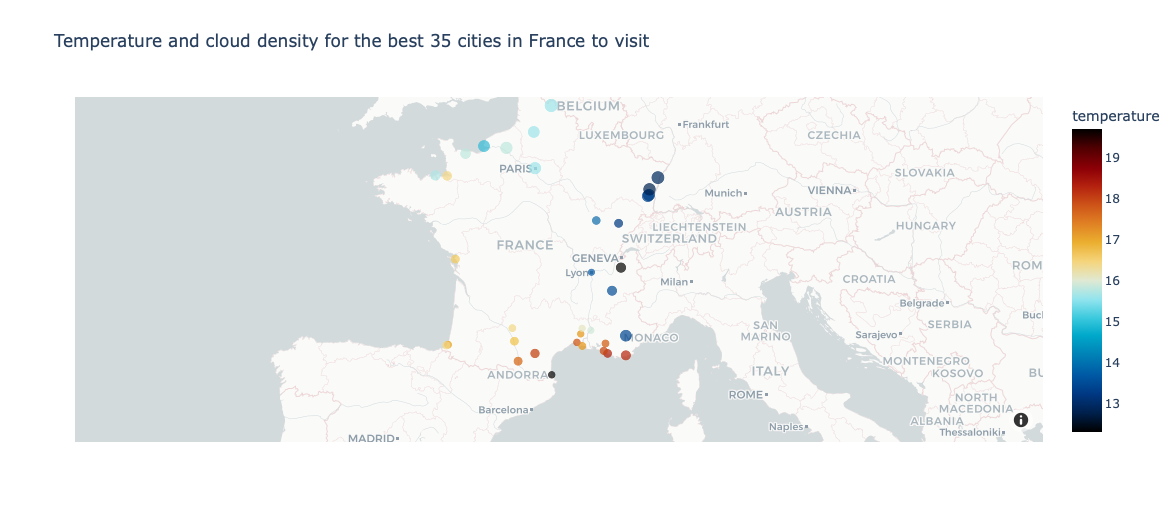

In [2]:
from IPython.display import display, Image
display(Image(filename='img/map_35_cities.png'))

In [27]:
#Top 5 cities in terms of temperature
top5_cities = df_cities_weather_7_next_days_average.sort_values(by=['temperature'], ascending=False)
top5_cities_selection  = top5_cities.iloc[:5 ,:]
top5_cities_selection

,city_name,city_latitude,city_longitude,temperature,wind_speed,clouds
12,Collioure,42.525050,3.083155,19.7,7.6,27.5
11,Cassis,43.214036,5.539632,18.4,5.4,36.5
9,Bormes-les-Mimosas,43.150697,6.341929,18.3,4.0,47.2
10,Carcassonne,43.213036,2.349107,18.1,5.8,41.5
24,Marseille,43.296174,5.369953,18.0,6.4,32.2


In [28]:
#Location of the top 5 cities
import plotly.express as px

fig = px.scatter_mapbox(top5_cities_selection,
                        lat="city_latitude",
                        lon="city_longitude",
                        size="temperature",
                        mapbox_style="carto-positron",
                        zoom = 6,
                        title = "Top 5 cities",
                        size_max = 20,
                        hover_name = "city_name")
fig.show()

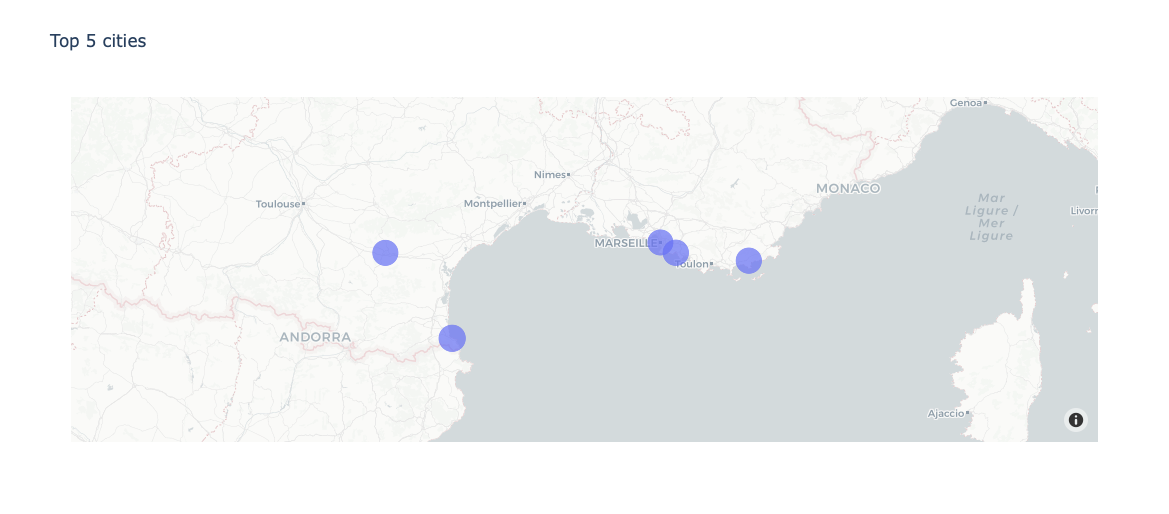

In [3]:
display(Image(filename='img/top_5.png'))

# Best hotels for the top 5 cities

## 1 - Carcassonne

In [29]:
#Top hotels in Carcassonne
df_hotels_carcassonne = df_hotels.loc[df_hotels["city_name"] == "Carcassonne"]
pd.options.mode.chained_assignment = None
df_hotels_carcassonne["latitude"] = df_hotels_carcassonne["latitude"].astype("float")
df_hotels_carcassonne["longitude"] = df_hotels_carcassonne["longitude"].astype("float")

In [30]:
fig = px.scatter_mapbox(df_hotels_carcassonne,
                        lat="latitude",
                        lon="longitude",
                        size="hotel_review",
                        mapbox_style="carto-positron",
                        zoom = 12,
                        color = "hotel_review",
                        color_continuous_scale=px.colors.sequential.Greens,
                        title = "Best hotels in Carcassonne",
                        size_max = 10,
                        hover_name = "hotel_name")
fig.show()

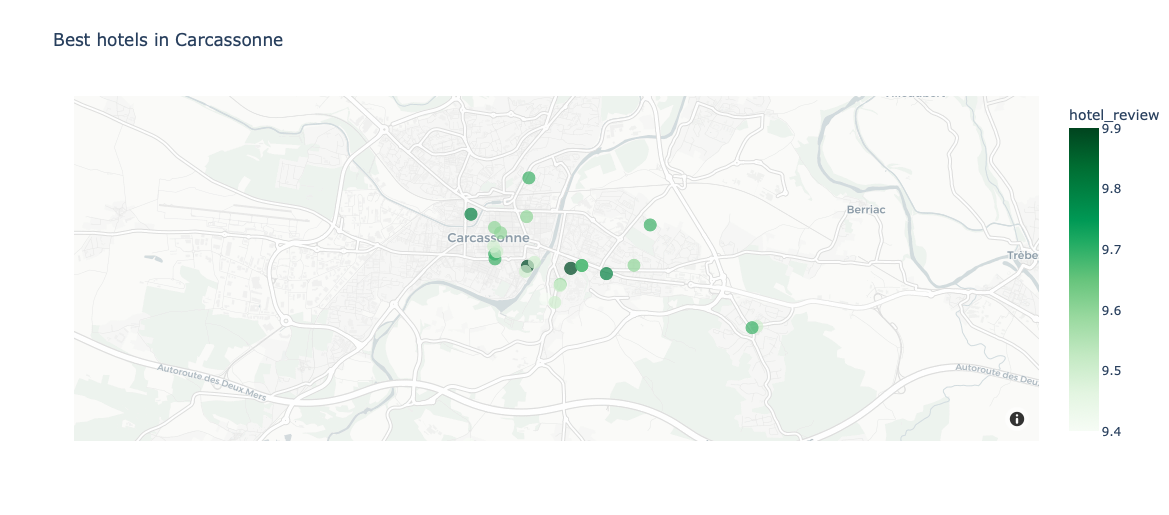

In [4]:
display(Image(filename='img/hotel_1.png'))

## 2-Nîmes

In [31]:
#Top hotels in Nîmes
df_hotels_nimes = df_hotels.loc[df_hotels["city_name"] == "Nîmes"]
pd.options.mode.chained_assignment = None
df_hotels_nimes["latitude"] = df_hotels_nimes["latitude"].astype("float")
df_hotels_nimes["longitude"] = df_hotels_nimes["longitude"].astype("float")

In [32]:
fig = px.scatter_mapbox(df_hotels_nimes,
                        lat="latitude",
                        lon="longitude",
                        size="hotel_review",
                        mapbox_style="carto-positron",
                        zoom = 12,
                        color = "hotel_review",
                        color_continuous_scale=px.colors.sequential.Greens,
                        title = "Best hotels in Nîmes",
                        size_max = 10,
                        hover_name = "hotel_name")
fig.show()

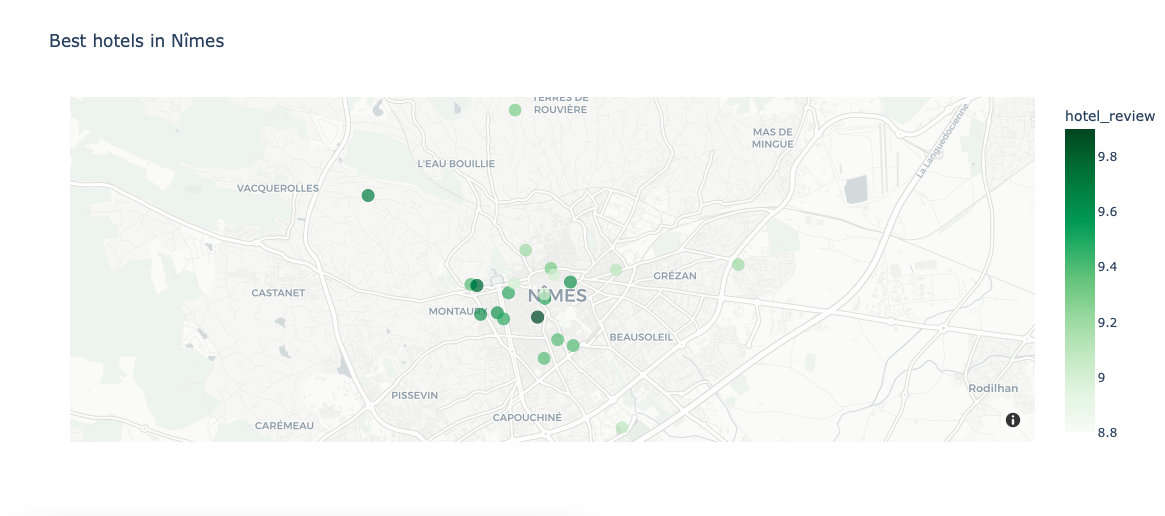

In [5]:
display(Image(filename='img/hotel_2.png'))

## 3-Aix-en-Provence

In [33]:
#Top hotels in Aix-en-Provence
df_hotels_aix_en_provence = df_hotels.loc[df_hotels["city_name"] == "Aix-en-Provence"]
pd.options.mode.chained_assignment = None
df_hotels_aix_en_provence["latitude"] = df_hotels_aix_en_provence["latitude"].astype("float")
df_hotels_aix_en_provence["longitude"] = df_hotels_aix_en_provence["longitude"].astype("float")

In [34]:
fig = px.scatter_mapbox(df_hotels_aix_en_provence,
                        lat="latitude",
                        lon="longitude",
                        size="hotel_review",
                        mapbox_style="carto-positron",
                        zoom = 12,
                        color = "hotel_review",
                        color_continuous_scale=px.colors.sequential.Greens,
                        title = "Best hotels in Aix-en-Provence",
                        size_max = 10,
                        hover_name = "hotel_name")
fig.show()

## 4-Cassis

In [35]:
#Top hotels in Cassis
df_hotels_cassis = df_hotels.loc[df_hotels["city_name"] == "Cassis"]
pd.options.mode.chained_assignment = None
df_hotels_cassis["latitude"] = df_hotels_cassis["latitude"].astype("float")
df_hotels_cassis["longitude"] = df_hotels_cassis["longitude"].astype("float")

In [36]:
fig = px.scatter_mapbox(df_hotels_cassis,
                        lat="latitude",
                        lon="longitude",
                        size="hotel_review",
                        mapbox_style="carto-positron",
                        zoom = 12,
                        color = "hotel_review",
                        color_continuous_scale=px.colors.sequential.Greens,
                        title = "Best hotels in Cassis",
                        size_max = 10,
                        hover_name = "hotel_name")
fig.show()

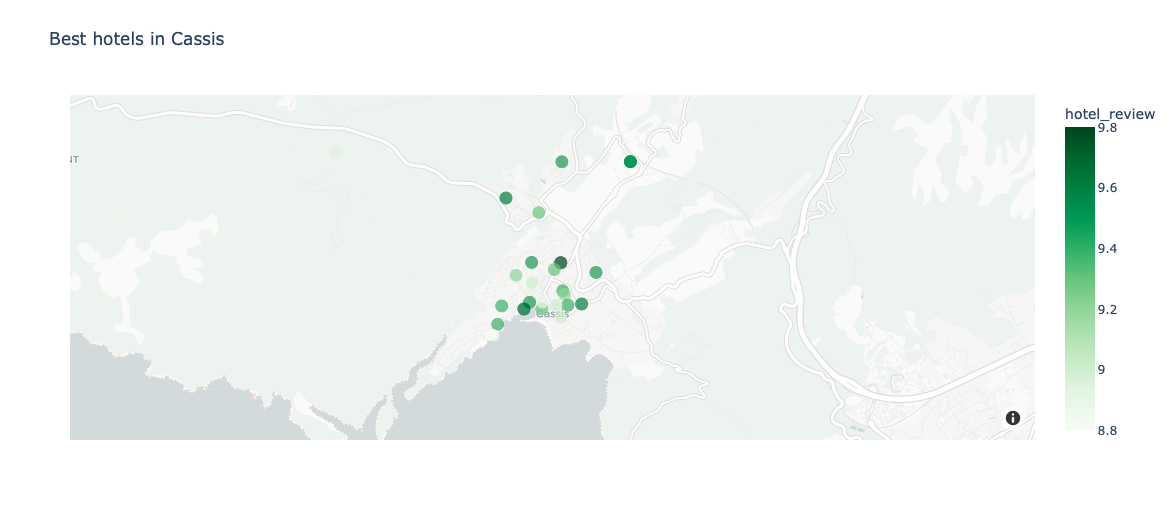

In [6]:
display(Image(filename='img/hotel_4.png'))

## 5-Bormes-les-Mimosas

In [37]:
#Top hotels in Bormes-les-Mimosas
df_hotels_bormes_les_mimosas = df_hotels.loc[df_hotels["city_name"] == "Bormes-les-Mimosas"]
pd.options.mode.chained_assignment = None
df_hotels_bormes_les_mimosas["latitude"] = df_hotels_bormes_les_mimosas["latitude"].astype("float")
df_hotels_bormes_les_mimosas["longitude"] = df_hotels_bormes_les_mimosas["longitude"].astype("float")

In [38]:
fig = px.scatter_mapbox(df_hotels_bormes_les_mimosas,
                        lat="latitude",
                        lon="longitude",
                        size="hotel_review",
                        mapbox_style="carto-positron",
                        zoom = 12,
                        color = "hotel_review",
                        color_continuous_scale=px.colors.sequential.Greens,
                        title = "Best hotels in Bormes-les_mimosas",
                        size_max = 10,
                        hover_name = "hotel_name")
fig.show()

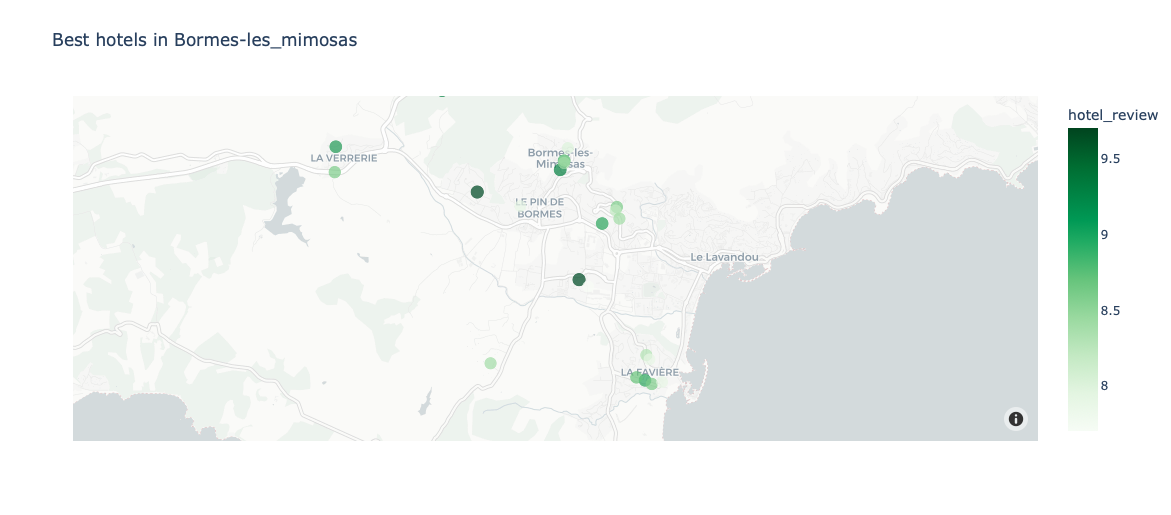

In [8]:
display(Image(filename='img/hotel_5.png'))